1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

Sampled c: 6.4251, Mean level mu: 3.1128


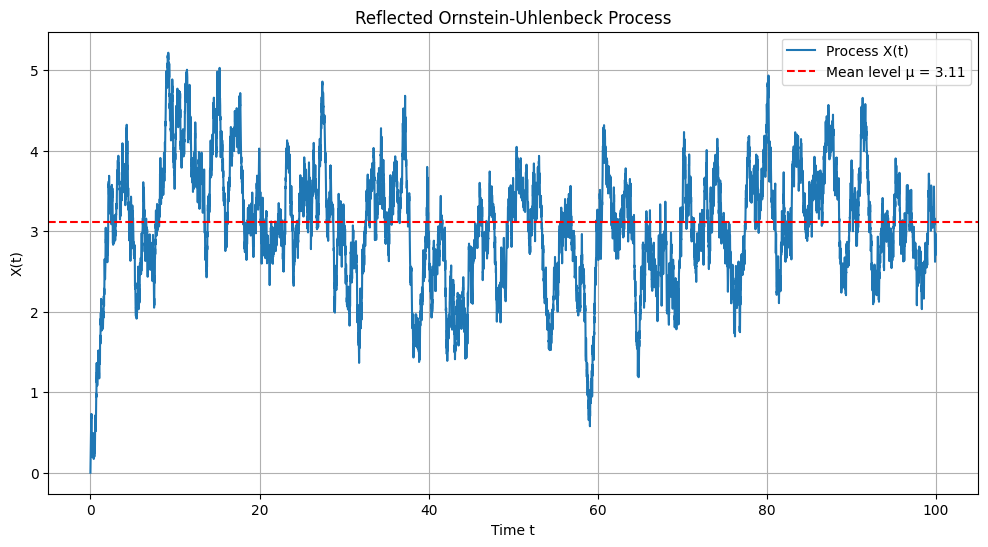

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = 0
b = 20
theta = 1.0
sigma = 1.0
Delta_t = 0.01
T = 100  # Total time
N = int(T / Delta_t)  # Number of time steps
t = np.linspace(0, T, N+1)

# Sample c and compute mu
c = np.random.uniform(a, b)
mu = (b - a) / c
print(f"Sampled c: {c:.4f}, Mean level mu: {mu:.4f}")

# Initialize X
X = np.zeros(N+1)
X[0] = a  # Starting at lower bound

# Simulate the process
np.random.seed(42)  # For reproducibility
for i in range(N):
    X[i+1] = X[i] + theta * (mu - X[i]) * Delta_t + sigma * np.sqrt(Delta_t) * np.random.randn()
    # Reflecting boundaries
    if X[i+1] < a:
        X[i+1] = 2 * a - X[i+1]
    elif X[i+1] > b:
        X[i+1] = 2 * b - X[i+1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t, X, label='Process X(t)')
plt.axhline(y=mu, color='r', linestyle='--', label=f'Mean level μ = {mu:.2f}')
plt.title('Reflected Ornstein-Uhlenbeck Process')
plt.xlabel('Time t')
plt.ylabel('X(t)')
plt.legend()
plt.grid(True)
plt.show()


2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

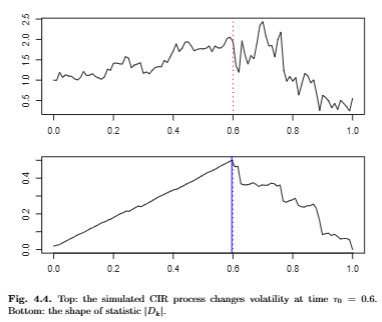

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 1000  # Number of time steps
dt = 1.0 / n  # Time step size
t = np.linspace(0, 1, n+1)  # Time grid
tau_0 = 0.6  # Change point
theta1 = 1.0  # Theta before change point
theta2 = 2.0  # Theta after change point

# Initialize the process
X = np.zeros(n+1)
X[0] = 1.0  # Initial condition

# Simulate the process
np.random.seed(42)  # For reproducibility
for i in range(n):
    theta = theta1 if t[i] < tau_0 else theta2
    dW = np.sqrt(dt) * np.random.randn()
    X[i+1] = X[i] + (6 - 2*X[i])*dt + theta * np.sqrt(max(X[i], 0)) * dW
    X[i+1] = max(X[i+1], 0)  # Ensure X remains non-negative


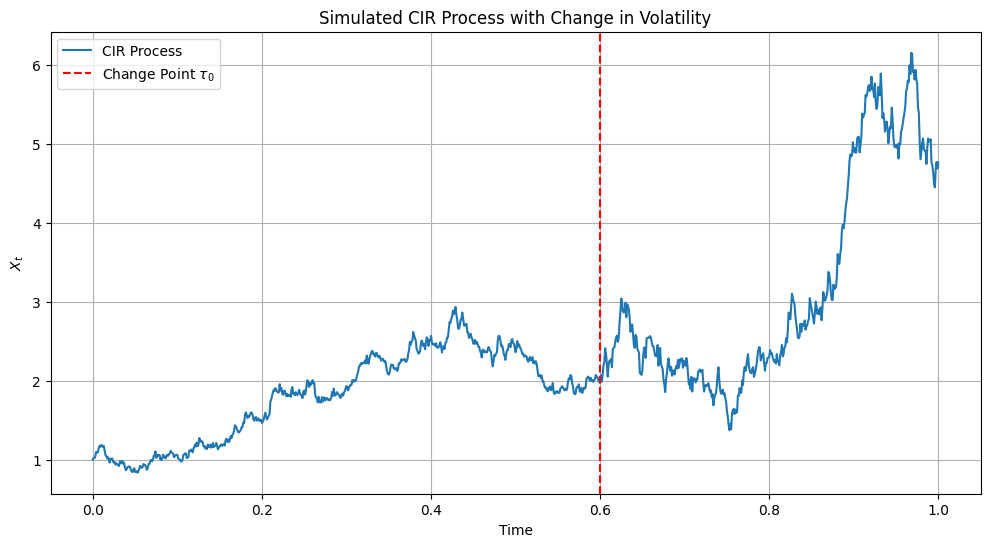

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(t, X, label='CIR Process')
plt.axvline(x=tau_0, color='r', linestyle='--', label=r'Change Point $\tau_0$')
plt.title('Simulated CIR Process with Change in Volatility')
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
# Kernel function (Epanechnikov kernel)
def K(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

# Bandwidth selection
h_n = 0.1

# Estimate b(x) at each X_i
b_hat = np.zeros(n)
for i in range(n):
    xi = X[i]
    # Compute weights
    weights = K((xi - X[:-1]) / h_n)
    numerator = np.sum(weights * (X[1:] - X[:-1]))
    denominator = dt * np.sum(weights)
    b_hat[i] = numerator / denominator if denominator != 0 else 0


In [75]:
Z = ((X[1:] - X[:-1]) - b_hat * dt) / np.sqrt(dt)


In [76]:
S_k = np.cumsum(Z**2)
S_n = S_k[-1]
D_k = (np.arange(1, n+1) / n) - (S_k / S_n)
abs_D_k = np.abs(D_k)


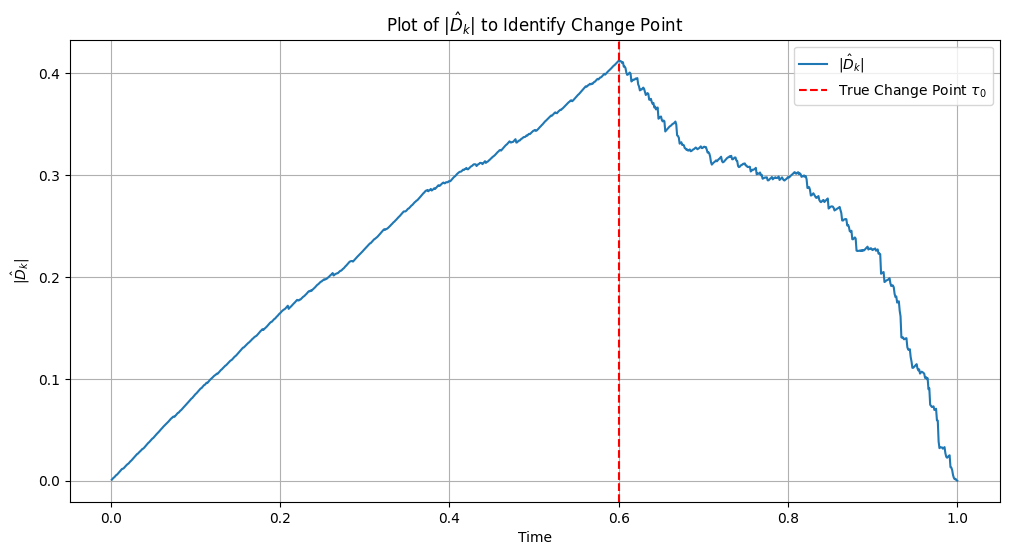

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(t[1:], abs_D_k, label=r'$|\hat{D}_k|$')
plt.axvline(x=tau_0, color='r', linestyle='--', label=r'True Change Point $\tau_0$')
plt.title(r'Plot of $|\hat{D}_k|$ to Identify Change Point')
plt.xlabel('Time')
plt.ylabel(r'$|\hat{D}_k|$')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
k_hat_0 = np.argmin(abs_D_k) + 1  # +1 because Python is zero-indexed
t_hat_0 = t[k_hat_0]

print(f"Estimated Change Point at k = {k_hat_0}, t = {t_hat_0:.4f}")
print(f"True Change Point at t = {tau_0}")


Estimated Change Point at k = 1000, t = 1.0000
True Change Point at t = 0.6


3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

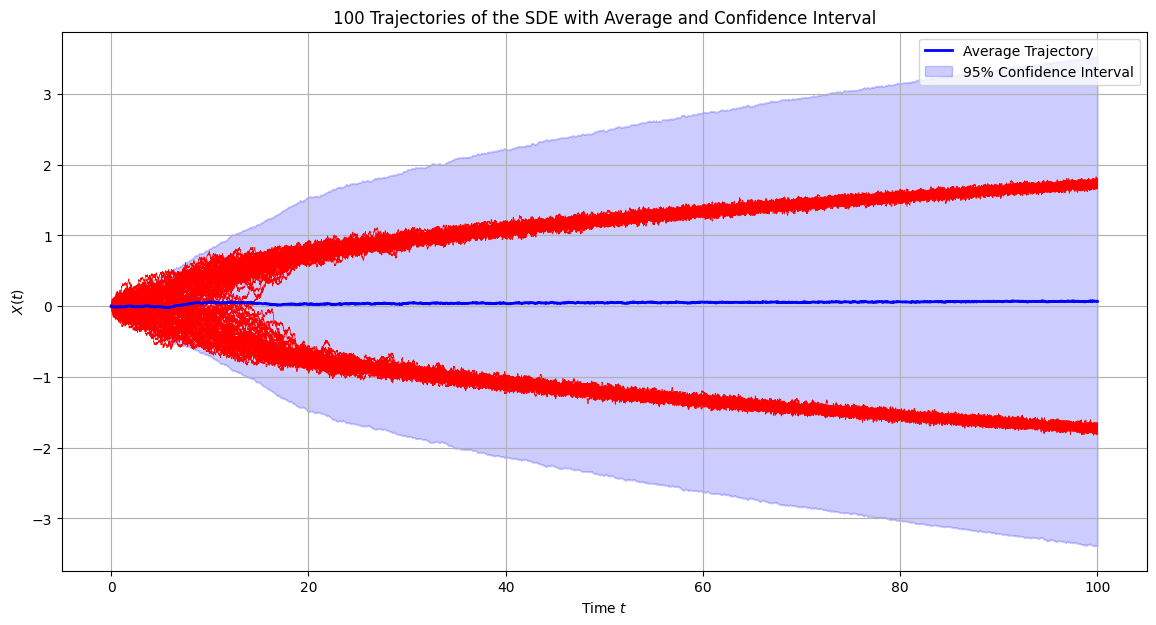

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x0 = 0.0          # Initial condition
t0 = 0.0          # Start time
T = 100.0         # End time
Delta_t = 0.01    # Time step size
N_steps = int((T - t0) / Delta_t)
t = np.linspace(t0, T, N_steps + 1)  # Time grid

N_trajectories = 100  # Number of trajectories

# Initialize array to store trajectories
X = np.zeros((N_trajectories, N_steps + 1))
X[:, 0] = x0

# Drift and diffusion functions
def mu(t, x):
    return 0.03 * t * x - x**3

def sigma(t, x):
    return 0.1

# Since sigma_x = 0, Milstein scheme simplifies to Euler-Maruyama
for i in range(N_trajectories):
    for n in range(N_steps):
        t_n = t[n]
        X_n = X[i, n]
        dW_n = np.sqrt(Delta_t) * np.random.randn()
        X[i, n+1] = X_n + mu(t_n, X_n) * Delta_t + sigma(t_n, X_n) * dW_n

# Compute average and standard deviation
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

# Plotting
plt.figure(figsize=(14, 7))

# Plot all trajectories
for i in range(N_trajectories):
    plt.plot(t, X[i, :], color='red', linewidth=0.5)

# Plot average trajectory
plt.plot(t, X_mean, color='blue', label='Average Trajectory', linewidth=2)

# Plot 95% confidence interval
plt.fill_between(t, X_mean - 2*X_std, X_mean + 2*X_std, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.title('100 Trajectories of the SDE with Average and Confidence Interval')
plt.xlabel('Time $t$')
plt.ylabel('$X(t)$')
plt.legend()
plt.grid(True)
plt.show()


4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


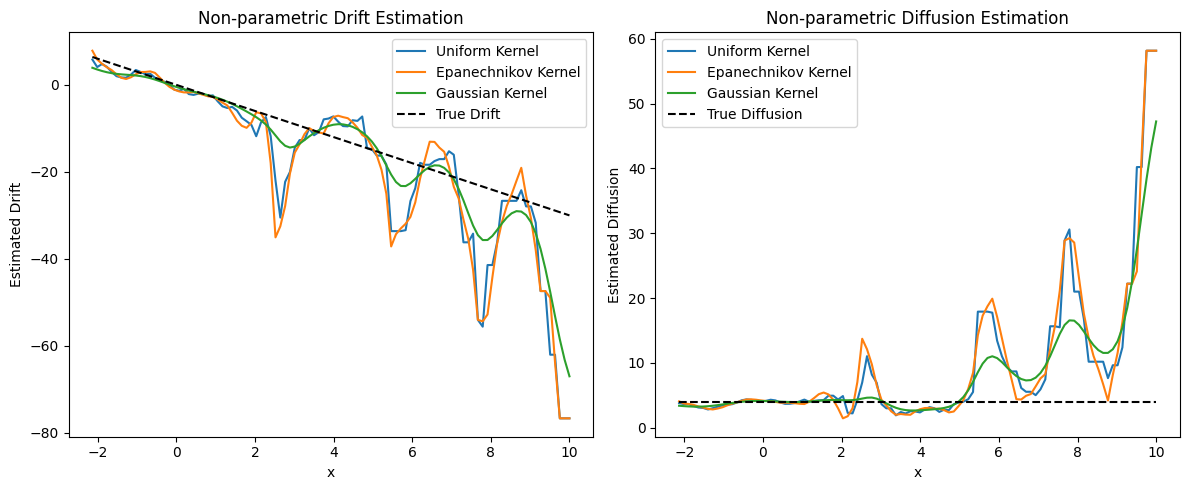

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
theta_1 = 0
theta_2 = 3
theta_3 = 2
X0 = 10
T = 10
dt = 0.01
n = int(T / dt)

# Time vector
t = np.linspace(0, T, n+1)

# Initialize X
X = np.zeros(n+1)
X[0] = X0

# Simulate the Ornstein-Uhlenbeck process
for i in range(n):
    dW = np.sqrt(dt) * np.random.randn()
    X[i+1] = X[i] + (theta_1 - theta_2 * X[i]) * dt + theta_3 * dW

# Compute increments
dX = np.diff(X)

# Define kernels
def uniform_kernel(u):
    return 0.5 * np.where(np.abs(u) <= 1, 1, 0)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * np.where(np.abs(u) <= 1, 1, 0)

def gaussian_kernel(u):
    return (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * u**2)

# Bandwidth
h = 0.5

# Points at which to estimate
x_grid = np.linspace(np.min(X), np.max(X), 100)

# Initialize estimates
mu_uniform = np.zeros_like(x_grid)
mu_epanechnikov = np.zeros_like(x_grid)
mu_gaussian = np.zeros_like(x_grid)
sigma2_uniform = np.zeros_like(x_grid)
sigma2_epanechnikov = np.zeros_like(x_grid)
sigma2_gaussian = np.zeros_like(x_grid)

# For each x in x_grid, compute estimates
for idx, x in enumerate(x_grid):
    # Compute kernel weights
    u = (X[:-1] - x) / h
    weights_uniform = uniform_kernel(u) / h
    weights_epanechnikov = epanechnikov_kernel(u) / h
    weights_gaussian = gaussian_kernel(u) / h

    sum_weights_uniform = np.sum(weights_uniform)
    sum_weights_epanechnikov = np.sum(weights_epanechnikov)
    sum_weights_gaussian = np.sum(weights_gaussian)

    if sum_weights_uniform > 0:
        mu_uniform[idx] = np.sum(weights_uniform * dX) / (sum_weights_uniform * dt)
        sigma2_uniform[idx] = np.sum(weights_uniform * (dX)**2) / (sum_weights_uniform * dt) - (mu_uniform[idx] * dt)**2
    else:
        mu_uniform[idx] = np.nan
        sigma2_uniform[idx] = np.nan

    if sum_weights_epanechnikov > 0:
        mu_epanechnikov[idx] = np.sum(weights_epanechnikov * dX) / (sum_weights_epanechnikov * dt)
        sigma2_epanechnikov[idx] = np.sum(weights_epanechnikov * (dX)**2) / (sum_weights_epanechnikov * dt) - (mu_epanechnikov[idx] * dt)**2
    else:
        mu_epanechnikov[idx] = np.nan
        sigma2_epanechnikov[idx] = np.nan

    if sum_weights_gaussian > 0:
        mu_gaussian[idx] = np.sum(weights_gaussian * dX) / (sum_weights_gaussian * dt)
        sigma2_gaussian[idx] = np.sum(weights_gaussian * (dX)**2) / (sum_weights_gaussian * dt) - (mu_gaussian[idx] * dt)**2
    else:
        mu_gaussian[idx] = np.nan
        sigma2_gaussian[idx] = np.nan

# Plotting
plt.figure(figsize=(12, 5))

# Plot drift estimates
plt.subplot(1, 2, 1)
plt.plot(x_grid, mu_uniform, label='Uniform Kernel')
plt.plot(x_grid, mu_epanechnikov, label='Epanechnikov Kernel')
plt.plot(x_grid, mu_gaussian, label='Gaussian Kernel')
plt.plot(x_grid, -theta_2 * x_grid, 'k--', label='True Drift')
plt.xlabel('x')
plt.ylabel('Estimated Drift')
plt.title('Non-parametric Drift Estimation')
plt.legend()

# Plot diffusion estimates
plt.subplot(1, 2, 2)
plt.plot(x_grid, sigma2_uniform, label='Uniform Kernel')
plt.plot(x_grid, sigma2_epanechnikov, label='Epanechnikov Kernel')
plt.plot(x_grid, sigma2_gaussian, label='Gaussian Kernel')
plt.plot(x_grid, np.full_like(x_grid, theta_3**2), 'k--', label='True Diffusion')
plt.xlabel('x')
plt.ylabel('Estimated Diffusion')
plt.title('Non-parametric Diffusion Estimation')
plt.legend()

plt.tight_layout()
plt.show()


5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [41]:
import pandas as pd

# Замените 'your_file.csv' на путь к вашему файлу
df = pd.read_csv('3.csv')

# Вывод первых 5 строк DataFrame
print(df.head())


   Unnamed: 0         0
0    0.000000  0.500000
1    0.003333  0.457925
2    0.006667  0.515366
3    0.010000  0.500405
4    0.013333  0.524208


In [42]:
import pandas as pd
import requests

# URL CSV файла
url = 'https://drive.usercontent.google.com/u/0/uc?id=1tUgKwm045TBADv47QVaufhsoVj1XY-A9&export=download'

# Загрузка файла
response = requests.get(url)
content = response.content

# Чтение файла в DataFrame
from io import BytesIO
df = pd.read_csv(BytesIO(content))

     Unnamed: 0         0
0      0.000000  0.500000
1      0.003333  0.457925
2      0.006667  0.515366
3      0.010000  0.500405
4      0.013333  0.524208
..          ...       ...
296    0.986667  1.286405
297    0.990000  1.269124
298    0.993333  1.273112
299    0.996667  1.257749
300    1.000000  1.223708

[301 rows x 2 columns]


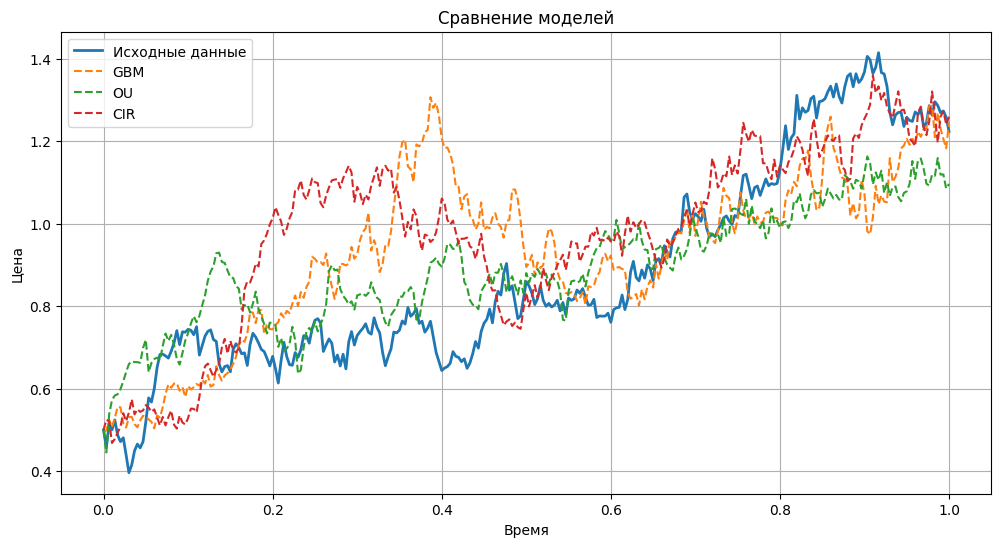

MSE GBM: 0.0381
MSE OU: 0.0199
MSE CIR: 0.0386

Лучшая модель: OU

Результат теста Дики-Фуллера:
ADF Statistic: -0.8938
p-value: 0.7900


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller

data = pd.DataFrame({'Time': df['Unnamed: 0'], 'Price': df['0']})

N = len(data['Time'])  # количество точек (дней)
dt = 1/N  # шаг времени
S0 = df['0'][0]  # начальная цена
mu_true = 0.05  # истинный дрейф
sigma_true = 0.2  # истинная волатильность

# Функция для оценки параметров GBM
def estimate_gbm_params(S):
    log_returns = np.log(S[1:].values / S[:-1].values)
    mu_hat = np.mean(log_returns) / dt
    sigma_hat = np.std(log_returns) / np.sqrt(dt)
    return mu_hat, sigma_hat

# Функция для оценки параметров OU
def estimate_ou_params(X):
    delta_X = np.diff(X)
    X_t = X[:-1]
    dt_array = np.full_like(X_t, dt)

    # Регрессия delta_X = theta*(mu - X_t)*dt + sigma*dW
    def ou_neg_log_likelihood(params):
        theta, mu, sigma = params
        residuals = delta_X - theta * (mu - X_t) * dt
        likelihoods = -0.5 * np.log(2 * np.pi * sigma**2 * dt) - (residuals**2) / (2 * sigma**2 * dt)
        return -np.sum(likelihoods)

    initial_guess = [1.0, np.mean(X), np.std(delta_X)]
    bounds = [(1e-5, None), (None, None), (1e-5, None)]
    result = minimize(ou_neg_log_likelihood, initial_guess, bounds=bounds)
    theta_hat, mu_hat, sigma_hat = result.x
    return theta_hat, mu_hat, sigma_hat

# Функция для оценки параметров CIR
def estimate_cir_params(X):
    delta_X = np.diff(X)
    X_t = X[:-1]
    dt_array = np.full_like(X_t, dt)

    # Логарифм правдоподобия для процесса CIR
    def cir_neg_log_likelihood(params):
        theta, mu, sigma = params
        residuals = delta_X - theta * (mu - X_t) * dt
        variances = sigma**2 * X_t * dt
        likelihoods = -0.5 * np.log(2 * np.pi * variances) - (residuals**2) / (2 * variances)
        return -np.sum(likelihoods)

    initial_guess = [1.0, np.mean(X), 0.1]
    bounds = [(1e-5, None), (1e-5, None), (1e-5, None)]
    result = minimize(cir_neg_log_likelihood, initial_guess, bounds=bounds)
    theta_hat, mu_hat, sigma_hat = result.x
    return theta_hat, mu_hat, sigma_hat

# Оценка параметров для каждой модели
mu_gbm, sigma_gbm = estimate_gbm_params(data['Price'])
theta_ou, mu_ou, sigma_ou = estimate_ou_params(data['Price'])
theta_cir, mu_cir, sigma_cir = estimate_cir_params(data['Price'])

# Симуляция каждого процесса с оцененными параметрами
def simulate_gbm(S0, mu, sigma, N, dt):
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)
    time = np.linspace(0, N*dt, N)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * time + sigma * W)
    return S

def simulate_ou(X0, theta, mu, sigma, N, dt):
    X = np.zeros(N)
    X[0] = X0
    for t in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * dW
    return X

def simulate_cir(X0, theta, mu, sigma, N, dt):
    X = np.zeros(N)
    X[0] = X0
    for t in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * np.sqrt(abs(X[t-1])) * dW
        # Обеспечение неотрицательности
        X[t] = max(X[t], 0)
    return X

# Симуляция
S_gbm = simulate_gbm(S0, mu_gbm, sigma_gbm, N, dt)
S_ou = simulate_ou(S0, theta_ou, mu_ou, sigma_ou, N, dt)
S_cir = simulate_cir(S0, theta_cir, mu_cir, sigma_cir, N, dt)

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Price'], label='Исходные данные', linewidth=2)
plt.plot(data['Time'], S_gbm, label='GBM', linestyle='--')
plt.plot(data['Time'], S_ou, label='OU', linestyle='--')
plt.plot(data['Time'], S_cir, label='CIR', linestyle='--')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.title('Сравнение моделей')
plt.legend()
plt.grid(True)
plt.show()

# Сравнение моделей по MSE
from sklearn.metrics import mean_squared_error

mse_gbm = mean_squared_error(data['Price'], S_gbm)
mse_ou = mean_squared_error(data['Price'], S_ou)
mse_cir = mean_squared_error(data['Price'], S_cir)

print(f"MSE GBM: {mse_gbm:.4f}")
print(f"MSE OU: {mse_ou:.4f}")
print(f"MSE CIR: {mse_cir:.4f}")

# Выбор лучшей модели
mse_values = {'GBM': mse_gbm, 'OU': mse_ou, 'CIR': mse_cir}
best_model = min(mse_values, key=mse_values.get)
print(f"\nЛучшая модель: {best_model}")

# Проверка стационарности для обоснования выбора
adf_result = adfuller(data['Price'])
print("\nРезультат теста Дики-Фуллера:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
